In [70]:
# import packages
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sg
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from sklearn.mixture import GaussianMixture
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings

In [63]:
def addLag(dataset, maxlag):
    # return the full dataset with lag
    LAG = np.arange(1,maxlag + 1)
    lagdata = pd.DataFrame([])
    for lag in LAG:
        varname = 'lag' + str(lag)
        lagdata[varname] = dataset['arrival'].loc[maxlag-lag:len(dataset)-lag-1].reset_index(drop = True)
    dataset = pd.concat([dataset.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)
    return dataset

In [64]:
FACILITY = ['JFK','LGA','PENN']
TRAFFIC = ['vehicle']
DATA = {}
maxlag = 12
for facility in FACILITY:
    dataset = pd.read_csv(facility + '.csv')
    DATA[facility] = addLag(dataset, maxlag)
    print(DATA[facility].shape)

(8748, 58)
(8748, 58)
(8748, 58)


## Baseline Models

In [65]:
warnings.simplefilter('ignore')
DECISIONTREE_CROSS_VAL_SCORE = {}
LINEAR_CROSS_VAL_SCORE = {}
RANDFOR_CROSS_VAL_SCORE = {}

for facility in FACILITY:
    featureData = DATA[facility].drop(['date','yellow','fhv','vehicle'], axis = 1)
    targetData = DATA[facility]['vehicle']
    # linear regression
    feature = featureData.columns.values.tolist()
    #print(feature)
    featureString = ''
    for i in range(0,len(feature)):
        featureString = featureString + '+' + feature[i]
    linearModel = smf.ols(formula = 'vehicle' + ' ~ ' + featureString, data = DATA[facility]).fit()
    # Decision Tree Regressor
    DECISIONTREE_CROSS_VAL_SCORE[facility] = cross_val_score(DecisionTreeRegressor(random_state = 0), featureData, targetData, cv = 10)
    RANDFOR_CROSS_VAL_SCORE[facility] = cross_val_score(RandomForestRegressor(random_state = 0), featureData, targetData, cv = 10)
    LINEAR_CROSS_VAL_SCORE[facility] = cross_val_score(LinearRegression(), featureData, targetData, cv = 10)

In [66]:
resultDictList = []
for key, value in  DECISIONTREE_CROSS_VAL_SCORE.items():
    res = {'model':'Decision Tree', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
for key, value in  LINEAR_CROSS_VAL_SCORE.items():
    res = {'model':'Linear Reg', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
for key, value in  RANDFOR_CROSS_VAL_SCORE.items():
    res = {'model':'RandomForest', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
baselinesResDf = pd.DataFrame(resultDictList)

In [67]:
pd.pivot_table(baselinesResDf, index = 'model', columns = 'Station', values = 'R_sqaure')

,model,Station,R_sqaure
0,Decision Tree,JFK,0.631279
1,Decision Tree,LGA,0.805173
2,Decision Tree,PENN,0.644307
3,Linear Reg,JFK,0.794170
4,Linear Reg,LGA,0.868927
5,Linear Reg,PENN,0.708499
6,RandomForest,JFK,0.798336
7,RandomForest,LGA,0.884615
8,RandomForest,PENN,0.795598


<Figure size 1080x1080 with 0 Axes>

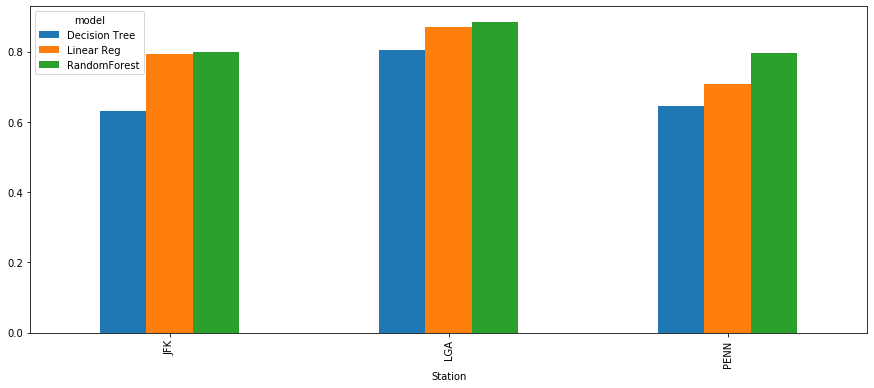

In [68]:
plt.figure(figsize=(15,15))
pd.pivot_table(baselinesResDf, index = 'Station', columns = 'model', values 
= 'R_sqaure').plot(kind = 'bar', figsize=(15,6))

## Random Grid Search for Hyper param tuning

In [76]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1, 112, 223, 334, 445, 556, 667, 778, 889, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [78]:
warnings.simplefilter('ignore')
RANDFOR_PARAM = {}

for facility in FACILITY:
    featureData = DATA[facility].drop(['date','yellow','fhv','vehicle'], axis = 1)
    targetData = DATA[facility]['vehicle']
    # linear regression
    feature = featureData.columns.values.tolist()
    #print(feature)
    featureString = ''
    for i in range(0,len(feature)):
        featureString = featureString + '+' + feature[i]
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, \
                                   cv = 10, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(featureData, targetData)
    RANDFOR_PARAM[facility] = rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.5min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.4min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 23.3min finished


In [79]:
RANDFOR_PARAM

{'JFK': {'n_estimators': 667,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 80,
  'bootstrap': False},
 'LGA': {'n_estimators': 334,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 100,
  'bootstrap': False},
 'PENN': {'n_estimators': 778,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 70,
  'bootstrap': False}}

## Training the optimized Model

In [86]:
optimized_RF = {}
for key, value in  RANDFOR_PARAM.items():
    rf = RandomForestRegressor(random_state = 0, n_estimators=value['n_estimators'], 
                               min_samples_split=value['min_samples_split'],
                               min_samples_leaf= value['min_samples_leaf'], 
                               max_features= value['max_features'],
                               max_depth= value['max_depth'], 
                               bootstrap= value['bootstrap'])
    optimized_RF[key] = rf

In [88]:
warnings.simplefilter('ignore')
DECISIONTREE_CROSS_VAL_SCORE = {}
LINEAR_CROSS_VAL_SCORE = {}
RANDFOR_CROSS_VAL_SCORE = {}
RANDFOR_OPT_CROSS_VAL_SCORE = {}

for facility in FACILITY:
    featureData = DATA[facility].drop(['date','yellow','fhv','vehicle'], axis = 1)
    targetData = DATA[facility]['vehicle']
    # linear regression
    feature = featureData.columns.values.tolist()
    #print(feature)
    featureString = ''
    for i in range(0,len(feature)):
        featureString = featureString + '+' + feature[i]
    linearModel = smf.ols(formula = 'vehicle' + ' ~ ' + featureString, data = DATA[facility]).fit()
    # Decision Tree Regressor
    DECISIONTREE_CROSS_VAL_SCORE[facility] = cross_val_score(DecisionTreeRegressor(random_state = 0), featureData, targetData, cv = 10)
    RANDFOR_CROSS_VAL_SCORE[facility] = cross_val_score(RandomForestRegressor(random_state = 0), featureData, targetData, cv = 10)
    RANDFOR_OPT_CROSS_VAL_SCORE[facility] = cross_val_score(optimized_RF[facility], featureData, targetData, cv = 10)
    LINEAR_CROSS_VAL_SCORE[facility] = cross_val_score(LinearRegression(), featureData, targetData, cv = 10)

In [89]:
resultDictList = []
for key, value in  DECISIONTREE_CROSS_VAL_SCORE.items():
    res = {'model':'Decision Tree', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
for key, value in  LINEAR_CROSS_VAL_SCORE.items():
    res = {'model':'Linear Reg', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
for key, value in  RANDFOR_CROSS_VAL_SCORE.items():
    res = {'model':'RandomForest', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
for key, value in  RANDFOR_OPT_CROSS_VAL_SCORE.items():
    res = {'model':'RandomForestOpt', 'Station':key, 'R_sqaure':np.mean(value)}
    resultDictList.append(res)
baselinesResDf = pd.DataFrame(resultDictList)

In [90]:
pd.pivot_table(baselinesResDf, index = 'model', columns = 'Station', values = 'R_sqaure')

Station,JFK,LGA,PENN
model,,,
Decision Tree,0.631279,0.805173,0.644307
Linear Reg,0.794170,0.868927,0.708499
RandomForest,0.798336,0.884615,0.795598
RandomForestOpt,0.829824,0.901467,0.825059


<Figure size 1080x1080 with 0 Axes>

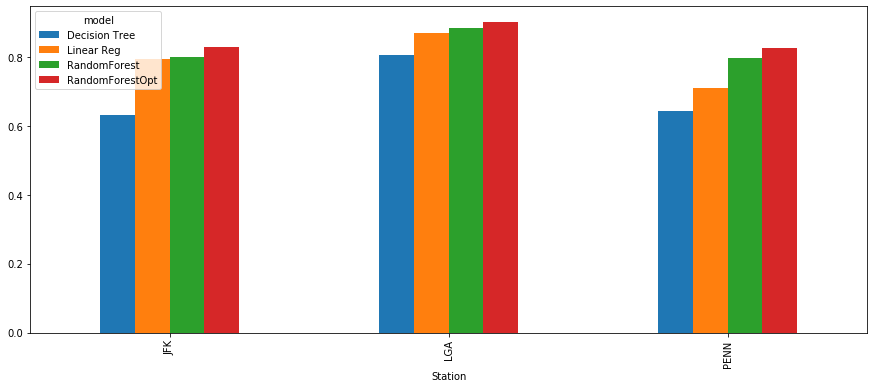

In [91]:
plt.figure(figsize=(15,15))
pd.pivot_table(baselinesResDf, index = 'Station', columns = 'model', values 
= 'R_sqaure').plot(kind = 'bar', figsize=(15,6))